# Importing Libraries

In [37]:
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from IPython.display import Audio

In [38]:
!nvidia-smi

Thu Sep  1 01:09:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |   1148MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading and Transforming Data

In [39]:
rate_divisor = 4

waveform, sample_rate = torchaudio.load("../data/chopin.wav")
idx = [i for i in range(waveform.shape[1]) if i % rate_divisor == 0]
waveform = waveform[1, idx].unsqueeze(0)
sample_rate //= rate_divisor

waveform.shape

torch.Size([1, 48234491])

In [40]:
sample_rate

11025

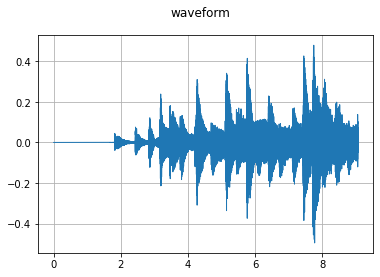

In [41]:
# View data
def plot_waveform(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
      axes = [axes]
  for c in range(num_channels):
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
      if num_channels > 1:
          axes[c].set_ylabel(f"Channel {c+1}")
  figure.suptitle("waveform")
  plt.show(block=False)

w = waveform[0]
w = w[:100000].unsqueeze(dim=0)
plot_waveform(w, sample_rate)

In [42]:
Audio(w.numpy()[0], rate=sample_rate)

In [43]:
# Define dataset
class AudioClips(torch.utils.data.Dataset):
  def __init__(self, waveform, clip_size):
    self.clips = []
    waveform = waveform.squeeze().unsqueeze(1)
    for i in range(0, waveform.shape[0]-clip_size, clip_size):
      self.clips.append(waveform[i:i+clip_size, :])
  
  def __len__(self):
    return len(self.clips)
  
  def __getitem__(self, idx):
    return self.clips[idx]

clips_data = AudioClips(waveform=waveform, clip_size=16384)
len(clips_data)

2943

In [44]:
# Create data loader
clips_loader = torch.utils.data.DataLoader(clips_data, batch_size=5, shuffle=True, drop_last=True)
next(iter(clips_loader)).shape

torch.Size([5, 16384, 1])

# Creating Model

In [45]:
# Set up GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
# Implement phase shuffling
class PhaseShuffle(nn.Module):
  def __init__(self, n):
    super(PhaseShuffle, self).__init__()
    self.n = n
  
  def forward(self, tensor):
    k_shuffle = torch.Tensor(tensor.shape[0]).random_(-self.n, to=self.n+1).numpy().astype(int)

    k_to_idxs = {}
    for idx, k in enumerate(k_shuffle):
      if k not in k_to_idxs:
        k_to_idxs[k] = [idx]
      else:
        k_to_idxs[k].append(idx)
    
    shuffled_tensor = tensor.clone()
    for k, idxs in k_to_idxs.items():
      if k > 0:
        shuffled_tensor[idxs] = nn.functional.pad(tensor[idxs][..., :-k].squeeze(), pad=[k, 0], mode="reflect")
      else:
        shuffled_tensor[idxs] = nn.functional.pad(tensor[idxs][..., -k:].squeeze(), pad=[0, -k], mode="reflect")
  
    return shuffled_tensor

In [47]:
class Generator(nn.Module):
  def __init__(self, d):
    super(Generator, self).__init__()
    self.d = d
    self.dense = nn.Linear(100, 256 * d)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.trans_conv1 = nn.ConvTranspose1d(16*d, 8*d, kernel_size=25, stride=4, padding=11, output_padding=1)
    self.trans_conv2 = nn.ConvTranspose1d(8*d, 4*d, kernel_size=25, stride=4, padding=11, output_padding=1)
    self.trans_conv3 = nn.ConvTranspose1d(4*d, 2*d, kernel_size=25, stride=4, padding=11, output_padding=1)
    self.trans_conv4 = nn.ConvTranspose1d(2*d, d, kernel_size=25, stride=4, padding=11, output_padding=1)
    self.trans_conv5 = nn.ConvTranspose1d(d, 1, kernel_size=25, stride=4, padding=11, output_padding=1)
  def forward(self, z):
    z = self.relu(self.dense(z)).view(z.shape[0], 16*self.d, 16)
    z = self.relu(self.trans_conv1(z))
    z = self.relu(self.trans_conv2(z))
    z = self.relu(self.trans_conv3(z))
    z = self.relu(self.trans_conv4(z))
    z = self.relu(self.trans_conv5(z))
    z = z.transpose(1, 2)
    z = self.tanh(z)
    return z

generator = Generator(4).to(device)

In [48]:
class Discriminator(nn.Module):
  def __init__(self, d):
    super(Discriminator, self).__init__()
    self.d = d
    self.lrelu = nn.LeakyReLU(0.2)
    self.shuffle = PhaseShuffle(2)
    self.conv1 = nn.Conv1d(1, d, kernel_size=25, stride=4, padding=11)
    self.conv2 = nn.Conv1d(d, 2*d, kernel_size=25, stride=4, padding=11)
    self.conv3 = nn.Conv1d(2*d, 4*d, kernel_size=25, stride=4, padding=11)
    self.conv4 = nn.Conv1d(4*d, 8*d, kernel_size=25, stride=4, padding=11)
    self.conv5 = nn.Conv1d(8*d, 16*d, kernel_size=25, stride=4, padding=11)
    self.dense = nn.Linear(256*d, 1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = x.transpose(1, 2)
    x = self.lrelu(self.conv1(x))
    x = self.shuffle(x)
    x = self.lrelu(self.conv2(x))
    x = self.shuffle(x)
    x = self.lrelu(self.conv3(x))
    x = self.shuffle(x)
    x = self.lrelu(self.conv4(x))
    x = self.shuffle(x)
    x = self.lrelu(self.conv5(x))
    x = x.view(x.shape[0], 256*self.d)
    x = self.sigmoid(self.dense(x))
    return x

discriminator = Discriminator(4).to(device)

# Training Model

In [49]:
loss_fn = nn.BCELoss()
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [51]:
epochs = 100

discriminator_losses = []
generator_losses = []

start_time = time.time()
for epoch in range(epochs):
  print(f"--------------------\nEPOCH: {epoch+1}\n--------------------")

  running_generator_loss = 0
  running_discriminator_loss = 0
  for batch, data in tqdm(enumerate(clips_loader)):
    data = data.to(device)
    
    batch_size = data.shape[0]

    discriminator.zero_grad()
    output = discriminator(data).squeeze()
    real_output = torch.ones((output.shape[0],), device=device)
    loss_discriminator_real = loss_fn(output, real_output)
    loss_discriminator_real.backward()

    z = torch.empty(batch_size, 100).uniform_(-1, to=1).to(device)
    fake_data = generator(z)
    output = discriminator(fake_data).squeeze()
    fake_output = torch.zeros((output.shape[0],), device=device)
    loss_discriminator_fake = loss_fn(output, fake_output)
    loss_discriminator_fake.backward()

    loss_discriminator = loss_discriminator_real.item() + loss_discriminator_fake.item()
    running_discriminator_loss += loss_discriminator
    optimizer_discriminator.step()

    generator.zero_grad()
    output = discriminator(fake_data).squeeze()
    loss_generator = loss_fn(output, real_output)
    running_generator_loss += loss_generator.item()
    optimizer_generator.step()
  
  print(f"Avg. Discriminator Loss: {running_discriminator_loss / len(clips_loader)}")
  print(f"Avg. Generator Loss: {running_generator_loss / len(clips_loader)}")

  generator_losses.append(running_generator_loss / len(clips_loader))
  discriminator_losses.append(running_discriminator_loss / len(clips_loader))

  print(f"Time: {time.time()-start_time:>2f} seconds\n")

print("Done!")

--------------------
EPOCH: 1
--------------------


588it [00:13, 43.24it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01496892397095
Time: 13.606998 seconds

--------------------
EPOCH: 2
--------------------


588it [00:13, 42.85it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00456310453869
Time: 27.342971 seconds

--------------------
EPOCH: 3
--------------------


588it [00:13, 43.05it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01169527793417
Time: 41.008996 seconds

--------------------
EPOCH: 4
--------------------


588it [00:13, 42.86it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01161636300638
Time: 54.739387 seconds

--------------------
EPOCH: 5
--------------------


588it [00:14, 41.62it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00374726535512
Time: 68.879653 seconds

--------------------
EPOCH: 6
--------------------


588it [00:13, 43.11it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01798544124681
Time: 82.527500 seconds

--------------------
EPOCH: 7
--------------------


588it [00:13, 43.22it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00841642885791
Time: 96.142523 seconds

--------------------
EPOCH: 8
--------------------


588it [00:13, 42.88it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00626541968106
Time: 109.865209 seconds

--------------------
EPOCH: 9
--------------------


588it [00:13, 42.95it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00513787821036
Time: 123.565409 seconds

--------------------
EPOCH: 10
--------------------


588it [00:13, 43.29it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.017443585558
Time: 137.157277 seconds

--------------------
EPOCH: 11
--------------------


588it [00:13, 43.17it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01262490927768
Time: 150.791027 seconds

--------------------
EPOCH: 12
--------------------


588it [00:13, 42.83it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01675283989938
Time: 164.531354 seconds

--------------------
EPOCH: 13
--------------------


588it [00:14, 41.56it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00757264117806
Time: 178.697651 seconds

--------------------
EPOCH: 14
--------------------


588it [00:13, 42.38it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00558668902131
Time: 192.579446 seconds

--------------------
EPOCH: 15
--------------------


588it [00:13, 43.01it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.003387541998
Time: 206.260870 seconds

--------------------
EPOCH: 16
--------------------


588it [00:13, 43.11it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0062155691134
Time: 219.910483 seconds

--------------------
EPOCH: 17
--------------------


588it [00:13, 43.03it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00230633482641
Time: 233.589032 seconds

--------------------
EPOCH: 18
--------------------


588it [00:13, 43.09it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00944608571578
Time: 247.245572 seconds

--------------------
EPOCH: 19
--------------------


588it [00:13, 43.15it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01030436665023
Time: 260.883176 seconds

--------------------
EPOCH: 20
--------------------


588it [00:13, 42.64it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00790043266453
Time: 274.683839 seconds

--------------------
EPOCH: 21
--------------------


588it [00:14, 41.40it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01105372111003
Time: 288.898794 seconds

--------------------
EPOCH: 22
--------------------


588it [00:13, 42.80it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01612937044935
Time: 302.645787 seconds

--------------------
EPOCH: 23
--------------------


588it [00:13, 43.07it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0101089477539
Time: 316.315128 seconds

--------------------
EPOCH: 24
--------------------


588it [00:13, 43.03it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00938305238478
Time: 329.992482 seconds

--------------------
EPOCH: 25
--------------------


588it [00:13, 42.84it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01530199634786
Time: 343.734452 seconds

--------------------
EPOCH: 26
--------------------


588it [00:13, 42.74it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01345573477194
Time: 357.500392 seconds

--------------------
EPOCH: 27
--------------------


588it [00:13, 43.37it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01118815675073
Time: 371.068974 seconds

--------------------
EPOCH: 28
--------------------


588it [00:13, 43.68it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01371867640489
Time: 384.544482 seconds

--------------------
EPOCH: 29
--------------------


588it [00:13, 42.95it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00511357573424
Time: 398.247775 seconds

--------------------
EPOCH: 30
--------------------


588it [00:13, 43.54it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01332260962246
Time: 411.761373 seconds

--------------------
EPOCH: 31
--------------------


588it [00:13, 44.17it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00892044897793
Time: 425.091056 seconds

--------------------
EPOCH: 32
--------------------


588it [00:13, 43.86it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0072172644998
Time: 438.507474 seconds

--------------------
EPOCH: 33
--------------------


588it [00:13, 44.13it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00749155939842
Time: 451.841886 seconds

--------------------
EPOCH: 34
--------------------


588it [00:13, 44.29it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01805332728794
Time: 465.128767 seconds

--------------------
EPOCH: 35
--------------------


588it [00:13, 44.45it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01235188594481
Time: 478.365734 seconds

--------------------
EPOCH: 36
--------------------


588it [00:13, 44.70it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00750807677808
Time: 491.530473 seconds

--------------------
EPOCH: 37
--------------------


588it [00:13, 43.76it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00910171197386
Time: 504.976356 seconds

--------------------
EPOCH: 38
--------------------


588it [00:13, 42.24it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01037565218348
Time: 518.907371 seconds

--------------------
EPOCH: 39
--------------------


588it [00:13, 44.58it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00886324149411
Time: 532.114889 seconds

--------------------
EPOCH: 40
--------------------


588it [00:13, 44.47it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.02011710445898
Time: 545.347042 seconds

--------------------
EPOCH: 41
--------------------


588it [00:13, 44.33it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00958206540062
Time: 558.622216 seconds

--------------------
EPOCH: 42
--------------------


588it [00:13, 44.63it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00605062886972
Time: 571.811261 seconds

--------------------
EPOCH: 43
--------------------


588it [00:13, 44.00it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00446200208599
Time: 585.185563 seconds

--------------------
EPOCH: 44
--------------------


588it [00:13, 43.97it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01306498780542
Time: 598.566578 seconds

--------------------
EPOCH: 45
--------------------


588it [00:13, 44.42it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00836096004564
Time: 611.812849 seconds

--------------------
EPOCH: 46
--------------------


588it [00:13, 42.59it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01613435291108
Time: 625.630360 seconds

--------------------
EPOCH: 47
--------------------


588it [00:13, 44.39it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01341900209181
Time: 638.895285 seconds

--------------------
EPOCH: 48
--------------------


588it [00:13, 44.18it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00794729894521
Time: 652.213479 seconds

--------------------
EPOCH: 49
--------------------


588it [00:13, 44.14it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 64.99850524850443
Time: 665.546647 seconds

--------------------
EPOCH: 50
--------------------


588it [00:13, 43.75it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0094095995637
Time: 678.993317 seconds

--------------------
EPOCH: 51
--------------------


588it [00:13, 44.13it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01854184209084
Time: 692.328690 seconds

--------------------
EPOCH: 52
--------------------


588it [00:13, 43.89it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00963513380816
Time: 705.733050 seconds

--------------------
EPOCH: 53
--------------------


588it [00:13, 44.20it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01551878533395
Time: 719.052631 seconds

--------------------
EPOCH: 54
--------------------


588it [00:13, 42.51it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01194399879093
Time: 732.892295 seconds

--------------------
EPOCH: 55
--------------------


588it [00:13, 43.97it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00239106262622
Time: 746.273669 seconds

--------------------
EPOCH: 56
--------------------


588it [00:13, 43.62it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00902340687863
Time: 759.763061 seconds

--------------------
EPOCH: 57
--------------------


588it [00:13, 44.22it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01168300343208
Time: 773.071048 seconds

--------------------
EPOCH: 58
--------------------


588it [00:13, 44.12it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0121218363444
Time: 786.406034 seconds

--------------------
EPOCH: 59
--------------------


588it [00:13, 44.17it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0138847325124
Time: 799.727936 seconds

--------------------
EPOCH: 60
--------------------


588it [00:13, 43.62it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00946813051392
Time: 813.223161 seconds

--------------------
EPOCH: 61
--------------------


588it [00:13, 43.72it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00630530532526
Time: 826.684477 seconds

--------------------
EPOCH: 62
--------------------


588it [00:13, 43.79it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01079772118808
Time: 840.123579 seconds

--------------------
EPOCH: 63
--------------------


588it [00:13, 42.55it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00290182982984
Time: 853.956129 seconds

--------------------
EPOCH: 64
--------------------


588it [00:13, 44.02it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01588982303126
Time: 867.324991 seconds

--------------------
EPOCH: 65
--------------------


588it [00:13, 43.62it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01009951481203
Time: 880.815074 seconds

--------------------
EPOCH: 66
--------------------


588it [00:13, 44.32it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00480865945622
Time: 894.097153 seconds

--------------------
EPOCH: 67
--------------------


588it [00:13, 44.00it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00675188440854
Time: 907.473055 seconds

--------------------
EPOCH: 68
--------------------


588it [00:13, 43.63it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00775452698169
Time: 920.961376 seconds

--------------------
EPOCH: 69
--------------------


588it [00:13, 43.95it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00771300646724
Time: 934.347287 seconds

--------------------
EPOCH: 70
--------------------


588it [00:13, 43.84it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0098355740917
Time: 947.768910 seconds

--------------------
EPOCH: 71
--------------------


588it [00:13, 42.31it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00543613823093
Time: 961.676102 seconds

--------------------
EPOCH: 72
--------------------


588it [00:13, 43.97it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00765878327039
Time: 975.057175 seconds

--------------------
EPOCH: 73
--------------------


588it [00:13, 44.14it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00497446903566
Time: 988.387625 seconds

--------------------
EPOCH: 74
--------------------


588it [00:13, 43.39it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0123087954359
Time: 1001.950628 seconds

--------------------
EPOCH: 75
--------------------


588it [00:13, 44.13it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00922639029366
Time: 1015.283729 seconds

--------------------
EPOCH: 76
--------------------


588it [00:13, 43.97it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0102242709828
Time: 1028.668930 seconds

--------------------
EPOCH: 77
--------------------


588it [00:13, 43.72it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00676535262542
Time: 1042.130640 seconds

--------------------
EPOCH: 78
--------------------


588it [00:13, 43.66it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01618705801413
Time: 1055.606568 seconds

--------------------
EPOCH: 79
--------------------


588it [00:13, 42.88it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00357912024673
Time: 1069.332140 seconds

--------------------
EPOCH: 80
--------------------


588it [00:13, 42.51it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 64.99826394943963
Time: 1083.170084 seconds

--------------------
EPOCH: 81
--------------------


588it [00:13, 43.98it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01030134343776
Time: 1096.550027 seconds

--------------------
EPOCH: 82
--------------------


588it [00:13, 43.96it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00645154836226
Time: 1109.935367 seconds

--------------------
EPOCH: 83
--------------------


588it [00:13, 43.39it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00190088700275
Time: 1123.496016 seconds

--------------------
EPOCH: 84
--------------------


588it [00:13, 43.74it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00058429743967
Time: 1136.951000 seconds

--------------------
EPOCH: 85
--------------------


588it [00:13, 44.01it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0061900988728
Time: 1150.326249 seconds

--------------------
EPOCH: 86
--------------------


588it [00:13, 43.71it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 64.99981795849443
Time: 1163.789565 seconds

--------------------
EPOCH: 87
--------------------


588it [00:13, 43.57it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01161544176998
Time: 1177.303173 seconds

--------------------
EPOCH: 88
--------------------


588it [00:13, 42.22it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01168919258377
Time: 1191.238699 seconds

--------------------
EPOCH: 89
--------------------


588it [00:13, 43.99it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.01485650717807
Time: 1204.615249 seconds

--------------------
EPOCH: 90
--------------------


588it [00:13, 43.88it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 64.9964588061482
Time: 1218.031363 seconds

--------------------
EPOCH: 91
--------------------


588it [00:13, 43.99it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00900935477951
Time: 1231.407469 seconds

--------------------
EPOCH: 92
--------------------


588it [00:13, 43.51it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00483213152204
Time: 1244.930473 seconds

--------------------
EPOCH: 93
--------------------


588it [00:13, 43.87it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00617173902032
Time: 1258.346675 seconds

--------------------
EPOCH: 94
--------------------


588it [00:13, 44.10it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00373377118792
Time: 1271.687086 seconds

--------------------
EPOCH: 95
--------------------


588it [00:13, 43.79it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00661657943206
Time: 1285.123387 seconds

--------------------
EPOCH: 96
--------------------


588it [00:13, 43.07it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0014073637878
Time: 1298.788776 seconds

--------------------
EPOCH: 97
--------------------


588it [00:13, 42.74it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0131062358415
Time: 1312.558338 seconds

--------------------
EPOCH: 98
--------------------


588it [00:13, 43.42it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00270920059307
Time: 1326.112654 seconds

--------------------
EPOCH: 99
--------------------


588it [00:13, 43.84it/s]


Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.0076044043716
Time: 1339.540138 seconds

--------------------
EPOCH: 100
--------------------


588it [00:13, 44.04it/s]

Avg. Discriminator Loss: 0.0
Avg. Generator Loss: 65.00761719788012
Time: 1352.903505 seconds

Done!


In [52]:
# Generate sample output
# [note: GAN may not converge without a significant number of epochs]
z = torch.empty(1, 100).uniform_(-1, to=1).to(device)
example_output = generator(z)
example_output
Audio(example_output.cpu().squeeze().detach().numpy(), rate=sample_rate)

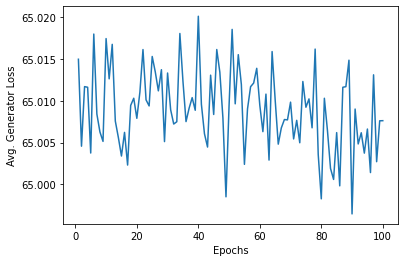

In [53]:
# Plot generator loss against epochs
plt.plot([i+1 for i in range(epochs)], generator_losses)

plt.xlabel("Epochs")
plt.ylabel("Avg. Generator Loss")

plt.show()

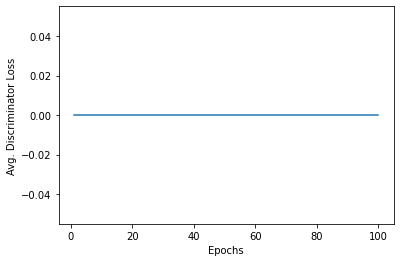

In [54]:
# Plot discriminator loss against epochs
plt.plot([i+1 for i in range(epochs)], discriminator_losses)

plt.xlabel("Epochs")
plt.ylabel("Avg. Discriminator Loss")

plt.show()

In [55]:
# Save model
print("Saving model...")
torch.save(discriminator, "../trained_models/chopin_discriminator")
torch.save(generator, "../trained_models/chopin_generator")
print("Saved!")

Saving model...
Saved!
